In [3]:
import os
from datetime import datetime
from contextlib import contextmanager

@contextmanager
def cwd(path):
    oldpwd=os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

THEME = "COLLABORATION"
SOURCE_FILE = "C:\\Users\\SB579KE\\Dev\\Exxon\\D1\\data2_textonly.csv"

RUN_NAME = f"{THEME}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"

WORKING_DIR = os.path.join(THEME, RUN_NAME)

def fp(path):
    return os.path.join(WORKING_DIR, path)

with open(SOURCE_FILE, 'rb') as source_file:
    if not os.path.isdir(THEME):
        os.mkdir(THEME)
    if not os.path.isdir(WORKING_DIR):
        os.mkdir(WORKING_DIR)
    with open(fp('data.csv'),'wb') as result_file:
        result_file.write(source_file.read())

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(fp('data.csv'))

filter_topics_includes = ["Collaboration"]

print(len(df))
len(df.dropna(subset=['topics']))
df = df.dropna(subset=['topics'])
df = df[sum([df['topics'].str.contains(topic) for topic in filter_topics_includes])>=1]
vb = df['text']
vb = vb.dropna().reset_index()
print(len(df))
# vb = vb.iloc[0:500] # for faster performance, limit data in

55072
5687


In [3]:
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
import pyLDAvis.gensim_models

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')
from itertools import chain

c:\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Python310\lib\site-packages\joblib\backports.py:7: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


In [4]:
vb = vb.rename(columns={'Q46_Strengthen_EN':'text'}).drop(columns=['index'])
vb

text
0     Quality and Efficiency. Safety and quality som...
1                                   ONE TEAM - ONE GOAL
2     Continue to knock down silos to improve collab...
3                                         collaboration
4                  Increase collaboration between GBU's
...                                                 ...
5682  I am working to improve our company's image an...
5683  I genuinely believe the culture of forced, com...
5684  Working to make teams and people feel trusted,...
5685  Relationships on a personal level within our c...
5686  I would say there is nothing I want to change ...

[5687 rows x 1 columns]

In [5]:
# clean
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

vb['clean'] = vb.text.apply(lambda x: clean(x))
vb

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SB579KE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SB579KE\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


text  \
0     Quality and Efficiency. Safety and quality som...   
1                                   ONE TEAM - ONE GOAL   
2     Continue to knock down silos to improve collab...   
3                                         collaboration   
4                  Increase collaboration between GBU's   
...                                                 ...   
5682  I am working to improve our company's image an...   
5683  I genuinely believe the culture of forced, com...   
5684  Working to make teams and people feel trusted,...   
5685  Relationships on a personal level within our c...   
5686  I would say there is nothing I want to change ...   

                                                  clean  
0     [quality, efficiency, safety, quality, sometim...  
1                                [one, team, one, goal]  
2     [continue, knock, silo, improve, collaboration...  
3                                       [collaboration]  
4                       [increase, collaboration, gbus]  
...                                                 ...  
5682  [working, improve, company, image, leader, mar...  
5683  [genuinely, believe, culture, forced, competit...  
5684  [working, make, team, people, feel, trusted, e...  
5685  [relationship, personal, level, within, cultur...  
5686  [would, say, nothing, want, change, at, want, ...  

[5687 rows x 2 columns]

In [6]:
dictionary = corpora.Dictionary(vb.clean)
print('Unique Words:', dictionary.num_nnz)

Unique Words: 89774


In [7]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in vb.clean]
print(len(doc_term_matrix))

5687


In [38]:
# generate model
import pickle
lda = gensim.models.ldamodel.LdaModel
num_topics = 5
ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0, random_state=42, alpha='auto', eta='auto', chunksize=20000, eval_every=6)
with open(f'ldamodel_{THEME}.model', 'wb') as file:
    pickle.dump(ldamodel, file)

In [39]:
# evaluate model
with open(f'ldamodel_{THEME}.model', 'rb') as file:
    ldamodel = pickle.load(file)
top_topics = ldamodel.top_topics(doc_term_matrix)
print(top_topics)

[([(0.032100715, 'trust'), (0.020001225, 'employee'), (0.01942664, 'people'), (0.013542966, 'company'), (0.0112009365, 'need'), (0.010658995, 'culture'), (0.010161045, 'management'), (0.009935055, 'change'), (0.0064402847, 'year'), (0.006012657, 'level'), (0.00587564, 'work'), (0.0058542406, 'feel'), (0.005451618, 'leadership'), (0.0050157113, 'make'), (0.0048338855, 'like'), (0.004754799, 'time'), (0.0045684325, 'care'), (0.0044266265, 'organization'), (0.004229798, 'way'), (0.004214797, 'decision')], -2.083996062302843), ([(0.015989225, 'people'), (0.013100498, 'work'), (0.012965037, 'employee'), (0.012202594, 'working'), (0.0106806755, 'performance'), (0.010227341, 'assessment'), (0.01006877, 'company'), (0.009623202, 'process'), (0.009463918, 'team'), (0.008705565, 'culture'), (0.008046977, 'system'), (0.008002276, 'need'), (0.006754907, 'make'), (0.006726454, 'change'), (0.0062942957, 'together'), (0.005866851, 'feel'), (0.0058575557, 'ranking'), (0.0055328654, 'competition'), (0.

In [40]:
# view model
with open(f'ldamodel_{THEME}.model', 'rb') as file:
    ldamodel = pickle.load(file)

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=True, mds='mmds')
pyLDAvis.display(lda_display)

In [10]:
lda_corpus = ldamodel[doc_term_matrix]

In [11]:
x = [doc for doc in lda_corpus]
x[3]

[(0, 0.10000014),
 (1, 0.100000136),
 (2, 0.10000014),
 (3, 0.100000136),
 (4, 0.5999995)]

In [12]:
scores = list(chain(*[[score for topic_id, score in topic] for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores) / len(scores)
print(threshold)

0.20000000019141487


In [13]:
cluster1 = [j for i,j in zip(lda_corpus,vb.index) if i[0][1] > threshold]
x = [doc for doc in lda_corpus]
prefix = 'cluster_fit_'
c_scores = [doc for doc in lda_corpus]

cluster_fit_cols = []

for i in range(len(lda_corpus[0])):
    cluster_id = i + 1
    new_cluster_fit_col = f"{prefix}{str(cluster_id)}"
    cluster_fit_cols.append(new_cluster_fit_col)
    vb[new_cluster_fit_col] = [c_scores[j][i][1] for j in range(len(lda_corpus))]


vb.to_csv('lda_cluster_results.csv')

In [14]:
# number_top_comments_per_cluster = 20
# max_comments = {}

# for cluster_fit_col in cluster_fit_cols:
#     max_fit_vb = vb.sort_values(cluster_fit_col,ascending=False).iloc[0:5]
#     max_comments[cluster_fit_col] = max_fit_vb.text.tolist()

In [15]:
# import json
# filename = "lda_cluster_results_with_top"
# json_path = f"{filename}.json"
# csv_path = f"{filename}.csv"
# with open(json_path,'w') as file:
#     json.dump(max_comments, file)
# pd.read_json(json_path).to_csv(csv_path)

In [16]:
result_best_fit_clusters = []

for index, row in vb.iterrows():
    best_fit_cluster = [cluster_col_name for cluster_col_name in cluster_fit_cols if row[cluster_col_name]>threshold][0]
    result_best_fit_clusters.append(best_fit_cluster)

best_fit_cluster_name = f'{THEME}_best_fit_cluster'

vb[best_fit_cluster_name] = result_best_fit_clusters

cluster_fit_1


cluster_fit_2


cluster_fit_3


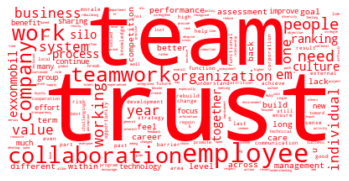

cluster_fit_4


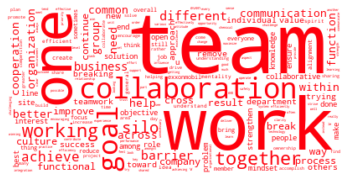

cluster_fit_5


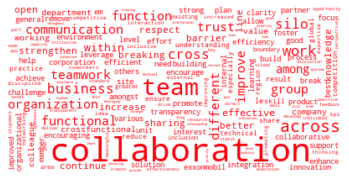

In [28]:
from wordcloud import WordCloud

def exxon_color_func(word, font_size, position, orientation, **kwargs):
    return "#fe000c"

cluster_fit_names = vb[f'{THEME}_best_fit_cluster'].unique().tolist()

excel_output_name = f"{THEME}_by_subtopic.xlsx"

with pd.ExcelWriter(excel_output_name) as xlsx_writer:
    for cluster_fit_name in sorted(cluster_fit_names):
        print(cluster_fit_name)
        # clean up the clean text for word cloud
        vb_current_cluster = vb[vb[best_fit_cluster_name]==cluster_fit_name]
        vb_current_cluster['clean_joined_text'] = [' '.join(clean_text_list) for clean_text_list in vb_current_cluster.clean.tolist()]

        # write to excel sheet
        sheet_name = f"{cluster_fit_name}"
        vb_current_cluster.to_excel(xlsx_writer, sheet_name=sheet_name, index=False)

        # generate word cloud
        word_cloud = WordCloud(collocations=False, background_color='white').generate(' '.join(vb_current_cluster.clean_joined_text.tolist()))
        plt.imshow(word_cloud.recolor(color_func=exxon_color_func, random_state=42), interpolation='bilinear')
        plt.axis('off')
        plt.savefig(f"wordcloud_{THEME}_{cluster_fit_name}.png")
        plt.show()

# Subtopic Analysis

## Cluster 1: Transparency and Organizational Trust

### Word Cloud

![](wordcloud_COLLABORATION_cluster_fit_1.png)

### Key Verbatims

* My observation is that trust has been lost/broken in ExxonMobil, and the culture we envision cannot be realized until trust is rebuilt. My belief is that unless the current PA process is critically examined with a willingness to adjust, trust cannot be rebuilt. When the revised PA process was introduced, employees were told that about 3% of employees would be rated as NSI. In the last two years, we have increased NSI to 8%, even in the midst of workforce reductions & high attrition. The result is that employee morale is low and a large portion of the employee population feels very vulnerable. Our employees should feel valued rather than vulnerable. Nobody enjoys seeing good employees subjected to the NSI/PIP wringer. This is beyond my DOAG.
* EM is a deeply fear-based culture.  This is one of the reasons that so many folks are leaving...I've talked to many folks before and after they've left.  Unfortunately, there are codified corporate mechanisms that rigidly ensure that the fear-based reality cannot change in the future.  I do what I can to craft a trust-based working environment that empowers staff.  I have seen both systems over my career, and it is clear that a trust-based environment outperforms a fear-based environment by a material margin.  Fear and trust are mutually exclusive, one cannot exist where the other lies.
* I don't feel empowered enough to make a dent in the existing culture of the company. Nevertheless, if I have a chance, I would identify ways to remove the fear of our dreaded performance assessment -a subjective and insightless- process from our employees. This is the primary reason preventing collaborative team work. Additionally, it disincentivizes people to think long-term and go for short-term subjective gains.

## Cluster 2: Feeling Supported
### Word Cloud

![](wordcloud_COLLABORATION_cluster_fit_2.png)

### Key Verbatims

* Team to team learning on interactions. One team learns something and it doesn't pass to different teams fast enough. We are a very large company and we learn a lot. These learnings should be able to disseminate quickly throughout the company so that we can learn quickly, fail fast, and spend less money for higher economic efficiency.
* My answer is about people care culture. Several of old-style leaders are still leading organization based on a tasked-oriented approach instead of people/relationship-oriented approach. In fact, those people have more power in organization than another style. Since I can't control those people I continue to start from myself and promote this culture whenever I have opportunities. I used to work with leaders who utilize people to drive results not result to drive/force people to do. In overall run, organization gets both target result and engaged workforce.
* The existing culture needs to be revamped not strengthened. The message we are getting is that the company doesn't really trust its employees. From needing special permission to access parts of the LAN we need to do our work, to demographics of the layoff, to positions open in the company, to the difference in pay between engineers and geologist, information is kept from employees. If you want people to stay in the company, change the culture.

## Cluster 3: Belongingness
### Word Cloud

![](./wordcloud_COLLABORATION_cluster_fit_3.png)

### Key Verbatims

* I would like to have the ability to strengthen and build relationships face-to-face with my Team and celebrate wins with my Team like was done in the past.  Part of competing to win is celebration of wins and enjoying the camaraderie of colleagues who helped to secure victories (both business and technical).  I think that this was missed in the description of "Compete to Win" in the EOL.  Anyone who has played sports in a competitive environment knows that following a major victory, the team celebrates together.  There will always be wins and losses.  Wins should be celebrated, and losses should be learned from to get better.  Also, celebration is different than recognition (I think we do a good job with recognition of achievements).
* Whichever team I am blessed to be a part of I am committed to uniting it as a better, stronger, more open and collaborative team. I strive to be inclusive of everyone on my team and colleagues that surround me. My Dad worked for this company...My husband works for this company...I work for this company...and my goal is to make it feel like it did back when we had family picnics and we treated each other with kindness, respect and a sense of community. We do things for each other because we WANT to help each other because of that sense of pride and together we are ONE TEAM.
* Community. I feel that with all of the brilliant collaborators at ExxonMobil, if we are not seeking out opportunities to connect and collaborate with others then we are missing out on potentially large value gains. While I feel a strong sense of connection with my immediate team, I believe that strengthening connections across teams, and ultimately helping everybody feel like they're working together towards clear and tangible goals that better the company and the world, is something critical that I can help strengthen and that others should feel empowered to strengthen, too.

## Cluster 4: Systematic Barriers
### Word Cloud

![](wordcloud_COLLABORATION_cluster_fit_4.png)

### Key Verbatims

* Improving process efficiency and rationalizing controls to remove or reduce barriers to increased productivity and success while still sufficiently accounting for risk. We are still far too process-driven and inward-looking right now.
* Inculcate more of a startup mentality - don't hit a barrier and give up in frustration.  Gently and respectfully push when you think management is unnecessarily putting up barriers to accomplishing effort
* (Hundreds of short comments along the lines of) Break the silos

## Cluster 5: Knowledge Sharing and Cross Function Collaboration
### Word Cloud

![](wordcloud_COLLABORATION_cluster_fit_5.png)

### Key Verbatims

* Better collaboration between groups, especially business and IT groups.  An effective digital transformation requires that there be better communication and collaboration between these groups.
* Improve collaboration between manufacturing groups (across technology areas); and across manufacturing and technology organization
* Collaboration and learnings across disciplines/experts.  Ability to leverage our internal resources to support initiatives across the corporation.